## Dataset

这里准备一下用`torch.utils.data.Dataset`来加载ashell数据集的类。

In [1]:
import torch
import torchaudio
import glob

class AshellDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, split='train'):
        self.wav_files = glob.glob(dataset_path +'/' + split + "/*/*.wav")

    def __getitem__(self, index):
        return [
            torchaudio.load(self.wav_files[index])[0],  # waveform of shape (channel, time)
            torch.load(self.wav_files[index].replace('.wav', '.pth'))
        ]

    def __len__(self):
        return len(self.wav_files)

In [2]:
train_dataset = AshellDataset('./data/aishell/wav', split='train')
dev_dataset = AshellDataset('./data/aishell/wav', split='dev')

## 简单查看数据

In [3]:
for i, train_data in enumerate(train_dataset):
    waveform, transcript = train_data[0], train_data[1]
    print("waveform: {}\ntranscript: {}".format(waveform, transcript))
    print("waveform shape: {}\ntranscript shape: {}".format(waveform.shape, transcript.shape))
    if i == 2:
        break

waveform: tensor([[-0.0003, -0.0005, -0.0005,  ..., -0.0034, -0.0031, -0.0035]])
transcript: tensor([ 132,   50,  291,   31,   45,  117, 1749,  154,  104,   88,  105,   32,
          17,  437,  285])
waveform shape: torch.Size([1, 95984])
transcript shape: torch.Size([15])
waveform: tensor([[-0.0002, -0.0003,  0.0000,  ..., -0.0005, -0.0006, -0.0005]])
transcript: tensor([  72,   45,   34,   40,   74,  157,  502,   17,  796,   22, 2444])
waveform shape: torch.Size([1, 61840])
transcript shape: torch.Size([11])
waveform: tensor([[-0.0004, -0.0004, -0.0003,  ..., -0.0016, -0.0016, -0.0017]])
transcript: tensor([ 100,  110,   70,  645, 1080,   46, 1805,  287,   31,  369,  417,  715,
         242,  365,  237,  437,  285,   73])
waveform shape: torch.Size([1, 86544])
transcript shape: torch.Size([18])


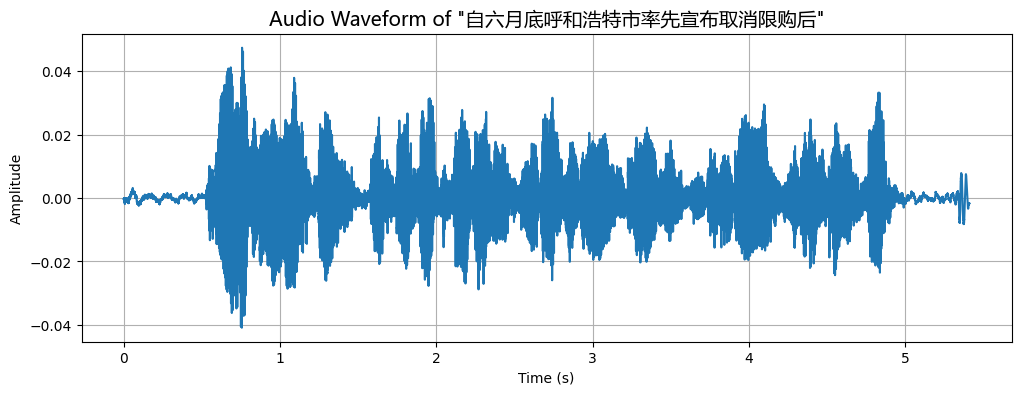

In [4]:
from utils.tokenizer import Vocabulary
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="./fonts/msyh.ttf", size=14)
vocab = Vocabulary.load('./data/aishell/vocab.txt')
train_data = train_dataset[2]
waveform, transcript = train_data[0], train_data[1]

# 获取波形数据的时间轴
sample_rate = 16000
num_samples = waveform.shape[1]
time_axis = torch.arange(0, num_samples) / sample_rate

# 获取文本标签
transcript = vocab.to_tokens(transcript.tolist())
transcript = ''.join(transcript)

# 绘制波形图
plt.figure(figsize=(12, 4))
plt.plot(time_axis.numpy(), waveform.t().numpy())
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Audio Waveform of "{transcript}"', fontproperties=font)
plt.grid()
plt.show()


## Dataloader

In [5]:
from torch.utils.data import DataLoader
from utils.datasets import collate_fn_pad
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,  
    collate_fn=collate_fn_pad, drop_last=True, 
)

In [8]:
for i, (waveforms, transcripts, waveform_lengths, transcript_lengths) in enumerate(train_loader):
    print("waveforms shape: {}\ntranscripts shape: {}".format(waveforms.shape, transcripts.shape))
    print("waveform_lengths: {}\ntranscript_lengths: {}".format(waveform_lengths, transcript_lengths))
    if i == 2:
        break

waveforms shape: torch.Size([32, 141391])
transcripts shape: torch.Size([32, 22])
waveform_lengths: tensor([141391, 122160, 114992, 107473,  98815,  94574,  93553,  93296,  91168,
         86351,  84336,  84031,  81871,  80434,  80432,  77488,  73633,  73519,
         73070,  70465,  68447,  64125,  62543,  61695,  60736,  59951,  58926,
         53199,  50817,  49568,  48543,  41471])
transcript_lengths: tensor([21, 18, 21, 22, 20, 12, 16, 16, 16, 16,  9, 16, 16, 14, 14, 10, 13, 14,
        15, 15, 13, 10, 11, 11, 10, 11,  9,  9,  9, 10, 11,  8])
waveforms shape: torch.Size([32, 145664])
transcripts shape: torch.Size([32, 24])
waveform_lengths: tensor([145664, 137568, 134528, 132672, 122705, 116750, 110336, 109953, 109824,
        102464,  99023,  98879,  98513,  90385,  89664,  86707,  72219,  69664,
         68959,  67936,  67264,  64912,  64222,  63553,  63232,  62336,  61539,
         58687,  55152,  54605,  43551,  23824])
transcript_lengths: tensor([23, 24, 21, 22, 21, 23, 22, 1

## 数据增强

In [13]:
prepocess_config = {
    "sample_rate": 16000,
    "win_length_ms": 25,
    "hop_length_ms": 10,
    "n_fft": 512,
    "n_mels": 80,
    "normalize": False,
    "mean": -5.6501,
    "std": 4.2280,
}

specAug_config = {
    "spec_augment": True,
    "mF": 2,
    "F": 27,
    "mT": 5,
    "pS": 0.05
}

In [14]:
from models.modules import AudioPreprocessing, SpecAugment
preprocess = AudioPreprocessing(**prepocess_config)
augment = SpecAugment(**specAug_config)

In [24]:
hop_length = int(16000 * 10) // 1000
95984 // hop_length + 1

600

In [18]:
for i, train_data in enumerate(train_dataset):
    waveform, transcript = train_data[0], train_data[1]
    waveform_len = torch.tensor([waveform.shape[1]])
    print("waveform shape: {}".format(waveform.shape))
    waveform, waveform_len = preprocess(waveform, waveform_len)
    print("waveform shape: {}".format(waveform.shape))
    waveform = augment(waveform, waveform_len)
    print("waveform shape: {}".format(waveform.shape))
    if i == 3:
        break

waveform shape: torch.Size([1, 95984])
waveform shape: torch.Size([1, 80, 600])
waveform shape: torch.Size([1, 80, 600])
waveform shape: torch.Size([1, 61840])
waveform shape: torch.Size([1, 80, 387])
waveform shape: torch.Size([1, 80, 387])
waveform shape: torch.Size([1, 86544])
waveform shape: torch.Size([1, 80, 541])
waveform shape: torch.Size([1, 80, 541])
waveform shape: torch.Size([1, 50672])
waveform shape: torch.Size([1, 80, 317])
waveform shape: torch.Size([1, 80, 317])
